# Sentiment Analysis

Using get_comments_from_video.py, I was able to collect more than 500k comments off Blackpink's latest music video "How You Like That". For our first pass with sentiment analysis, we'll use a rule-based approach with Vader Sentiment. Thus, we'll also need to apply some classical preprocessing techniques to get our texts ready for sentiment analysis.

Before we start pre-processing our corpus for sentiment analysis, let's transform our data. We need to know which language each comment is in. And, since I was interested in the comments that specifically talked about one member, I also added an extra column … To do these, we will
1. Strip URLs (useful for pre-processing as well)
2. Strip emojis (we append the stripped comments to a new column since we want to keep the emojis for sentiment analysis)
3. Label each comment by the predicted language (due to model inaccuracy, some comments will not be labeled) 
4. Label each comment by the unique name of the group member that shows up

Afterwards, we'll apply some pre-processing techniques to normalize our text as much as possible. This is to reduce the size of our vocabulary and prevent outliers from messing with predictions ( maybe research this part). 

1. Remove URLs (handled in text transformation)
2. Handle emojis: add whitespace between consecutive emojis, etc. (this time we don't remove them)
3. Tokenization
4. Handle contractions
5. Part-of-speech tagging
6. Lemmatization
7. Remove whitespaces and punctuation

For this project, we may not want to remove emojis. This is because emojis are another type of data that we can perform sentiment analysis on. Since these comments are from social media, we're bound to have a lot of misspellings and emojis. We'd be losing out on a lot of data if we were to remove them. 

# 0. Importing the data

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import regex
import emoji
import dateutil.parser
import spacy
import json

import fasttext
PRETRAINED_MODEL_PATH = 'lid.176.bin'

from util import get_results_of_comparison
%matplotlib inline

In [3]:
# this allows us to convert time as YouTube stores it (ISO 8601)
def parse_yt_datetime(date):
    return dateutil.parser.parse(date)

In [4]:
# import our data 
blackpink = pd.read_csv('comments_by_time_june27_july08.csv', lineterminator='\n')

# convert ISO 8601 to Python datetime
blackpink['Updated At'] = blackpink['Updated At'].apply(lambda x: parse_yt_datetime(x))

blackpink.to_csv("python_datetime_june27_july08.csv", index=False)

In [5]:
blackpink.keys()

Index(['Comment', 'Comment ID', 'Replies Count', 'Like Count', 'Updated At'], dtype='object')

In [6]:
blackpink.head(10)

,Comment,Comment ID,Replies Count,Like Count,Updated At
0,😂😂😂😂😂,UgyJUozOOb_ng7rmIMp4AaABAg,0,0,2020-06-27 08:20:15+00:00
1,ستريم ستريم ستريم نبي نوصل ٨٢ قبل مايخلص اليوم...,Ugw8PM1u0bsWOMzzGCZ4AaABAg,1,0,2020-06-27 08:20:15+00:00
2,81M congratulations blink blackpink,Ugymm_tQHxSp7U2wH8t4AaABAg,0,1,2020-06-27 08:20:15+00:00
3,#1 in Poland,UgwymZEm7y2vyppPyCh4AaABAg,0,1,2020-06-27 08:20:15+00:00
4,QUEEN BLACKPINK,UgzotV8vjKKQonnXCUN4AaABAg,0,1,2020-06-27 08:20:15+00:00
5,After 1 year:/🤲🏻,UgzNygGLylMKf9W5TVZ4AaABAg,0,0,2020-06-27 08:20:16+00:00
6,New record.,Ugx30JVR3BL6Mhx_j5F4AaABAg,0,1,2020-06-27 08:20:16+00:00
7,Bp broke the record for most viewed mv in 24/h...,UgyEbIl9NuXnSMx21NB4AaABAg,1,7,2020-06-27 08:20:16+00:00
8,ดูอีกกี่รอบ ก็ใช้คำว่าสวยได้เปลืองมาก 😄,Ugxoz3mXLw3V9Xkkd6V4AaABAg,0,2,2020-06-27 08:20:16+00:00
9,100m view in 24hour please😍😍,UgwkB-_LwsAnVxMYJTJ4AaABAg,0,0,2020-06-27 08:20:17+00:00


# Create a column called Lang and start labeling it with the correct language, or "url" if it's pure url, or "emoji" if it only contains emoji

We'll set the default value to an empty string "". This is so that later on, while detecting languages, we can keep track of and skip over comments that are entirely emoji and url. And by setting this column now, we can double check that all comments in the dataset have been accounted for.

In [18]:
blackpink['Lang'] = ''

# 1. Remove urls

In [19]:
# https://medium.com/r/?url=https%3A%2F%2Fstackoverflow.com%2Fa%2F40823105
# r'S' matches anything until next whitespace
def remove_urls(text):
    return re.sub(r'https?://\S+', '', text)

In [20]:
stripped_urls = [remove_urls(comment) for comment in blackpink['Comment'].values]

In [21]:
# Here's how we find how many comments were purely urls
unique_comments = Counter(stripped_urls)
print(unique_comments[''])

2793


In [22]:
blackpink['Stripped Urls'] = [remove_urls(comment) for comment in blackpink['Comment'].values]

Update our lang column.

In [23]:
blackpink.loc[blackpink['Stripped Urls'] == '', 'Lang'] = 'url'
blackpink.loc[blackpink['Stripped Urls'] != '', 'Lang'] = 'lang'

In [34]:
blackpink['Lang'].value_counts()

lang    487960
url       2793
Name: Lang, dtype: int64

In [33]:
blackpink['Lang'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

lang    99.4%
url      0.6%
Name: Lang, dtype: object

# 2. Emojis

Again, emojis are a crucial part of communication on social media. They can amplify or distort the meaning of a comment by concurring or disagreeing with the sentiment of just the text portion. For purposes of language detection, however, we'll remove them temporarily, and save the stripped results into a new column.

Since the total list of emojis is constantly, expanding, you want to make sure that the function you write includes all the emojis currently available. For this, I've imported the emoji library and will be using it to tag and remove emojis.

In [43]:
import demoji
# demoji.download_codes()

In [45]:
demoji.replace("🥺hello there how are you", "")

'hello there how are you'

In [46]:
def remove_emojis(text):
    return demoji.replace(text, "")

In [47]:
blackpink['Stripped Emojis'] = [remove_emojis(comment) for comment in blackpink['Stripped Urls']]

In [48]:
len(blackpink[blackpink['Stripped Emojis'] == '' ])

56036

Seems like we have 56036 comments that are now empty. We have to remember that some of them are already empty strings from before (we removed a few pure urls from our dataset.) So the 56k comments are a combination of pure emojis and pure urls.

In [55]:
blackpink.loc[(blackpink['Lang'] == 'lang') & (blackpink['Stripped Emojis'] == ''), 'Lang'] = 'emoji'

In [56]:
pure_emojis = len(blackpink[blackpink['Lang'] == 'emoji'])
print(pure_emojis, pure_urls, pure_emojis + pure_urls)

53243 2793 56036


Fortunately, the numbers do add up. So 56036 is the sum total of pure emojis and pure urls.

# 3. Label each comment by the predicted language

We have to be careful with multi-language texts. We can expect the comments under BlackPink's video to be multi-lingual, since BlackPink, and the K-Pop industry in general, has plenty of international fans. To avoid applying sentiment and other NLP libraries on non-English languages, we want to distinguish between English and non-English comments.

In [1]:
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

NameError: name 'fasttext' is not defined

In [297]:
mask = (blackpink['Lang'] == 'lang') # create a mask over the comments that are not purely emoji or url
detect_languages = blackpink[mask]
print(len(detect_languages))

434630


In [383]:
print(len(blackpink) - len(detect_languages))

56123


Lastly, let's make everything lowercase. 

Make sure that the numbers add up. We predict language based on 'Stripped Emojis', which itself is built off 'Stripped Urls'. Removing most of these artifacts should make it easier for the model to predict the language of our texts.

In [294]:
blackpink['lowercase_and_all_stripped'] = [comment.lower() for comment in blackpink['Stripped Emojis']]

In [299]:
detect_langs = [model.predict(" ".join(comment.split()) )\
                                                     for comment in detect_languages['lowercase_and_all_stripped']]

In [300]:
# Let's take a look at what is returned in detect_langs
detect_langs[0]

(('__label__ar',), array([0.99710673]))

FastText returns labels in ISO 639, so we'll use pycountry to convert these into full names of languages.

In [254]:
from pycountry import languages

We're also going to keep only labels with greater than 90 % confidence.

In [301]:
just_langs = []
for lang in detect_langs:
    if lang[1][0] > .6:
        try:
            just_langs.append(languages.lookup(lang[0][0][9:]).name)
        except:
            just_langs.append('unk')
    else:
        just_langs.append("unsure")

In [302]:
len(just_langs)

434630

In [303]:
len(blackpink[blackpink['Lang'] == 'lang']['Stripped Emojis'])

434630

Fasttext does not do too well when the comments are too short, or the words are too misspelled. It's up to the user to determine how confidence a prediction should be in order for it to be kept.

In [306]:
blackpink.loc[blackpink['Lang'] == 'lang', 'expanded_langs'] = just_langs

blackpink['expanded_langs'].count()

Just double checking to make sure that we didn't accidentally mis-tag anything.

In [310]:
blackpink.loc[blackpink['Lang'] == 'emoji', 'expanded_langs'] = 'emoji'
blackpink.loc[blackpink['Lang'] == 'url', 'expanded_langs'] = 'url'

Let's save our work right now, in case anything should happen to our notebook.

In [321]:
blackpink.to_csv("carefully.csv", index=False)

In [382]:
blackpink['Lang'].value_counts()

lang     434630
emoji     53330
url        2793
Name: Lang, dtype: int64

# 4. Label each comment with the name of the members that show up in the comment, if any

In [385]:
pattern = {'jennie', 'jisoo', 'rose|rosé', 'lisa'}

In [398]:
def find_unique_member(member_name):
    return blackpink['Comment'].str.contains(member_name, case=False) & \
~blackpink['Comment'].str.contains("|".join(pattern - {member_name}), case=False)

In [403]:
test = find_unique_member("rose|rosé")

In [404]:
len(blackpink[test])

6969

In [405]:
only_jennie = find_unique_member("jennie")
only_jisoo = find_unique_member("jisoo")
only_rose = find_unique_member("rose|rosé")
only_lisa = find_unique_member("lisa")


In [406]:
print(blackpink[only_jennie].shape, 
      blackpink[only_jisoo].shape, 
      blackpink[only_rose].shape, 
      blackpink[only_lisa].shape, 
      blackpink.shape)

(8423, 12) (9149, 12) (6969, 12) (17740, 12) (490753, 12)


Does this surprise you? Lisa has the most comments with just her name, folloed by Jisoo, Jennie, and finally Rose.

In [330]:
blackpink.loc[only_jennie, 'member'] = 'jennie'
blackpink.loc[only_jisoo, 'member'] = 'jisoo'
blackpink.loc[only_rose, 'member'] = 'rose'
blackpink.loc[only_lisa, 'member'] = 'lisa'

Verify that the remaining comments add up to the total number of comments.

In [340]:
len(blackpink) - len(blackpink[blackpink['member'].isnull()])

42281

In [344]:
len(blackpink[(blackpink['member'] == 'jennie') | \
          (blackpink['member'] == 'jisoo') | \
          (blackpink['member'] == 'rose') | \
          (blackpink['member'] == 'lisa') ])

42281

In [407]:
blackpink.loc[pd.isna(blackpink["member"]), 'member'] = 'none'

len(blackpink[blackpink['member'] == 'none'])

448472

# We just finished transforming the data!

Now we can get started on the pre-processing.
The first step has already been completed: in blackpink['Stripped Urls'], we've already removed all urls from a comment. Here's what's left: 

2. Handle emojis: add whitespace between consecutive emojis, etc. (this time we don't remove them)
3. Tokenization
4. Handle contractions
5. Part-of-speech tagging
6. Lemmatization
7. Remove whitespaces and punctuation

Let's handle punctuations and symbols without erasing emojis

In [409]:
def get_emojis(text):
    just_emojis = ""
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            just_emojis += word
    return Counter(just_emojis)

In [410]:
all_emojis = Counter(get_emojis("".join(stripped_urls)))

In [411]:
len(all_emojis)

1326

In [373]:
analyzer = SentimentIntensityAnalyzer()

In [374]:
print(analyzer.polarity_scores("🤮"))

print(analyzer.polarity_scores("👑"))

print(analyzer.polarity_scores("🔥"))

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.34}


It doesn't recognize 🤮 as a negative emoji, doesn't recognize 👑 as a positive emoji, and misclassifies 🔥 as negative when it has a positive connotation on social media.


In [375]:
print(analyzer.polarity_scores("yaaaas kill it! slay!"))

{'neg': 0.638, 'neu': 0.362, 'pos': 0.0, 'compound': -0.7418}


It also doesn't recognize slang (kill it and slay are from ballroom.) https://www.inquirer.com/philly/columnists/elizabeth_wellington/beyonce-vogue-september-issue-rihanna-slay-20180814.html

Thus, we have to approach the results of vader sentiment with a grain of salt. We'll eventually try to train a model that can do better, but for now it'll suit our purposes.

Let's collect all the emojis in our corpus.

# Working with 1326 emojis TODO: clean up this part

Out of the list, we'll redefine the below and create a new dictionary out of it. Then, we'll drop all emojis with a count less than 10.

Some that can be very ambiguous, such as '🤔', I decided to just leave them be. Or animal faces, like frog_face, pig_face, ... left those.
Others fell below cutoff: double_exclamation_mark, funeral_urn, hot_pepper
Others, collision, fire, we gave it word equivalent.


In [412]:
with open('redefined.json', 'r') as fp:
    redefined_meaning = json.load(fp)


In [413]:
redefined_meaning['🔥']

'_great!'

In [414]:
def replace_emojis_or_word(text, redefined_meaning):
    new_text = []
    text = re.split(r'(\s+)', text)
    
    for word in text:
        has_emoji = False
        idx_begin = 0
        for idx_end, letter in enumerate(word):
            if any(char in emoji.UNICODE_EMOJI for char in letter):
                # append non-emoji text
                new_text += redefined_meaning.get(word[idx_begin:idx_end], word[idx_begin:idx_end]) + ' '
                # set new head to one after current idx_end
                idx_begin = idx_end + 1

                # add the emoji we just found
                new_text += redefined_meaning.get(letter, letter) + ' '
                has_emoji = True

        if not has_emoji:
            new_text += redefined_meaning.get(word, word)

    return ''.join(new_text)



In [415]:
replace_emojis_or_word('Owh my goot lisa- its sou beautiful😮😮😮', redefined_meaning)

'Owh my goot lisa- its sou beautiful 😮  😮  😮 '

In [416]:
blackpink['Modified Emojis and Words'] = [replace_emojis_or_word(comment, redefined_meaning) for comment in stripped_urls]


In [417]:
blackpink.head(10)

,Comment,Comment ID,Replies Count,Like Count,Updated At,Stripped Urls,Lang,Modified Emojis and Words,Stripped Emojis,lowercase_and_all_stripped,expanded_langs,member
0,😂😂😂😂😂,UgyJUozOOb_ng7rmIMp4AaABAg,0,0,2020-06-27 08:20:15+00:00,😂😂😂😂😂,emoji,_obnoxious _obnoxious _obnoxious _obnoxiou...,,,emoji,none
1,ستريم ستريم ستريم نبي نوصل ٨٢ قبل مايخلص اليوم...,Ugw8PM1u0bsWOMzzGCZ4AaABAg,1,0,2020-06-27 08:20:15+00:00,ستريم ستريم ستريم نبي نوصل ٨٢ قبل مايخلص اليوم...,lang,ستريم ستريم ستريم نبي نوصل ٨٢ قبل مايخلص اليوم...,ستريم ستريم ستريم نبي نوصل ٨٢ قبل مايخلص اليوم...,ستريم ستريم ستريم نبي نوصل ٨٢ قبل مايخلص اليوم...,Arabic,none
2,81M congratulations blink blackpink,Ugymm_tQHxSp7U2wH8t4AaABAg,0,1,2020-06-27 08:20:15+00:00,81M congratulations blink blackpink,lang,81M congratulations blink blackpink,81M congratulations blink blackpink,81m congratulations blink blackpink,unsure,none
3,#1 in Poland,UgwymZEm7y2vyppPyCh4AaABAg,0,1,2020-06-27 08:20:15+00:00,#1 in Poland,lang,#1 in Poland,#1 in Poland,#1 in poland,En,none
4,QUEEN BLACKPINK,UgzotV8vjKKQonnXCUN4AaABAg,0,1,2020-06-27 08:20:15+00:00,QUEEN BLACKPINK,lang,QUEEN BLACKPINK,QUEEN BLACKPINK,queen blackpink,unsure,none
5,After 1 year:/🤲🏻,UgzNygGLylMKf9W5TVZ4AaABAg,0,0,2020-06-27 08:20:16+00:00,After 1 year:/🤲🏻,lang,After 1 year:/ 🤲 🏻,After 1 year:/,after 1 year:/,En,none
6,New record.,Ugx30JVR3BL6Mhx_j5F4AaABAg,0,1,2020-06-27 08:20:16+00:00,New record.,lang,New record.,New record.,new record.,En,none
7,Bp broke the record for most viewed mv in 24/h...,UgyEbIl9NuXnSMx21NB4AaABAg,1,7,2020-06-27 08:20:16+00:00,Bp broke the record for most viewed mv in 24/h...,lang,Bp broke the record for most viewed mv in 24/h...,Bp broke the record for most viewed mv in 24/h...,bp broke the record for most viewed mv in 24/h...,En,none
8,ดูอีกกี่รอบ ก็ใช้คำว่าสวยได้เปลืองมาก 😄,Ugxoz3mXLw3V9Xkkd6V4AaABAg,0,2,2020-06-27 08:20:16+00:00,ดูอีกกี่รอบ ก็ใช้คำว่าสวยได้เปลืองมาก 😄,lang,ดูอีกกี่รอบ ก็ใช้คำว่าสวยได้เปลืองมาก 😄,ดูอีกกี่รอบ ก็ใช้คำว่าสวยได้เปลืองมาก,ดูอีกกี่รอบ ก็ใช้คำว่าสวยได้เปลืองมาก,Thai,none
9,100m view in 24hour please😍😍,UgwkB-_LwsAnVxMYJTJ4AaABAg,0,0,2020-06-27 08:20:17+00:00,100m view in 24hour please😍😍,lang,100m view in 24hour please 😍 😍,100m view in 24hour please,100m view in 24hour please,En,none


In [418]:
def strip_symbols(text):
    
    # https://stackoverflow.com/questions/58833864/python-regex-removing-all-special-characters-and-numbers-not-attached-to-words
    return ''.join(re.findall(r'(?:[^\W\d_]+\d|\d+[^\W\d_])[^\W_]*|[^\W\d_]+', text))


In [419]:
strip_symbols("**Hello there beautiful😮😮😮")

'Hellotherebeautiful'

In [420]:
def keep_emojis_strip_symbols(text):
    stripped = []
    
    text_to_words = text.split()
    for word in text_to_words:
        data = regex.findall(r'\X', word)
        has_emoji = False
        the_emoji = []
        for char_combo in data:
            if any(char in emoji.UNICODE_EMOJI for char in char_combo):
                has_emoji = True
                break
            else:
                continue
                
        # after analyzing the characters of a word
        if has_emoji:
            stripped.append(''.join(word))
        else:
            stripped.append(strip_symbols(word))
    return ' '.join(stripped)

In [421]:
keep_emojis_strip_symbols("owh my goot lisa its sou beautiful 😮 😮 😮")


'owh my goot lisa its sou beautiful 😮 😮 😮'

In [235]:
import en_core_web_md

In [237]:
nlp = en_core_web_md.load()

In [238]:
def clean_comments(document):
    cleaned = []
    for comment in nlp.pipe(document, disable=['parser']):
        sentence = [keep_emojis_strip_symbols(word.lemma_) \
                    if word.lemma_ != '-PRON-' else word.text \
                    for word in comment]
        cleaned.append(' '.join(sentence))
    return cleaned

In [245]:
cleaned_jennie_english = clean_comments(jennie)
cleaned_jennie_sentiment = [analyzer.polarity_scores(doc)['compound'] for doc in cleaned_jennie_english]

cleaned_jisoo_english = clean_comments(jisoo)
cleaned_jisoo_sentiment = [analyzer.polarity_scores(doc)['compound'] for doc in cleaned_jisoo_english]

cleaned_rose_english = clean_comments(rose)
cleaned_rose_sentiment = [analyzer.polarity_scores(comment)['compound'] for comment in cleaned_rose_english]

cleaned_lisa_english = clean_comments(lisa)
cleaned_lisa_sentiment = [analyzer.polarity_scores(comment)['compound'] for comment in cleaned_lisa_english]

In [250]:
def compare_diffs(cleaned_comments, orig_comments, cleaned_sent, orig_sent, indices):
    agree = 0
    disagree = 0
    for i in indices:
        if cleaned_sent[i] != orig_sent[i]:
            disagree += 1
            print(cleaned_sent[i], ":", orig_sent[i])
            print(cleaned_comments[i])
            print(orig_comments[i])
            print()
        else:
            agree += 1
    print(agree, disagree)
    

In [251]:
jennie_sentiment = [analyzer.polarity_scores(doc)['compound'] for doc in jennie]

In [ ]:
compare_diffs(cleaned_jennie_english, jennie,
              cleaned_jennie_sentiment, jennie_sentiment, [i for i in range(len(cleaned_jennie_english))])

[Text(0.5, 0, 'Lisa')]

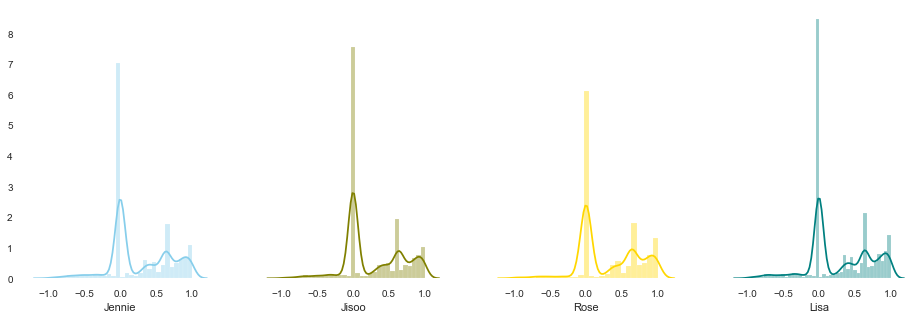

In [254]:
f, axes = plt.subplots(1, 4, figsize=(16, 5), sharex=True, sharey=True)
sns.distplot(cleaned_jennie_sentiment , color="skyblue", ax=axes[0])
sns.distplot(cleaned_jisoo_sentiment, color="olive", ax=axes[1])
sns.distplot(cleaned_rose_sentiment , color="gold", ax=axes[2])
sns.distplot(cleaned_lisa_sentiment , color="teal", ax=axes[3])

axes[0].set(xlabel='Jennie')
axes[1].set(xlabel='Jisoo')
axes[2].set(xlabel='Rose')
axes[3].set(xlabel='Lisa')

In [281]:
for comment, sentiment in zip(lisa, cleaned_lisa_sentiment):
    if -0.05 < sentiment < 0.05:
        print(comment)
        print("--")

Lisa with black dress is soooo-
--
LALISA​ MANOBAN! - Thailand
--
Lisa's rap is fantasic!!!
--
Lisaaaaa
--
LiSA
--
Lisa
--
Lisaaaa
--
Lisaa
--
Lisa Queen? Get em gurl!
--
Lisa!!!
--
Lisaaaaa
--
Lalisaaaaaaa
--
Lisa
--
Lalisa Lisa <3
--
Lisaaaa
--
Lisa te amo eres la mejor casate conmigo
--
LISAAAAAAAAAAAA
--
queen lalisa manoban
--
I really apriciate Lisa color hair
--
Lisaaaaa
--
LISA!
--
lisa
--
Lisa katerinaya benzwmiş
--
Omg Lisa is so so so so HOT!!!!
--
Lisa es muy hermosa y su rap es omg ;)
--
LISA
--
LALISA QUEEN
--
The donkey behind Lisa is the Hitters
--
Lisa always get my all attention...
--
Lisaaaaaaaaaaaaaa
--
ME : HANA DUL SET!
LISA : BLACKPINK PARAM BUM BUM BUM!
--
LISA
--
Lisa
--
lisa
--
Lalisa Manobal
--
Lisa so swang!!!
--
LISA
--
Lisa queen
--
Why lisa with lisa hair
--
Lisa in a Pink Hair is a lit!
--
LISA
--
Gw baru tau klo di part nya lisa pas masuk rap ada kuda
--
LALISAAAA!!!!!
--
Lisa Queen
--
Lisaaaaaaaa
--
Lisa: look at me know look at you

Me:Lisa are you tr

--
LISA SWAG IS EVERYTHING !
--
Lisaaa
--
How you like that❤️ lisa so swag🔥🔥🔥
--
Lisa's rap
--
1:20 did anyone noticed Lord Ganesha's statue near Lisa
--
Kim jisoo 
Kim jeenie
Park rosie
La lisa
--
Lisa hylt
--
Lisa
--
LISA'S RAP
--
Take a shot,everytime Lisa changes her hair
--
/I'm wearing pijama/
Lisa: look at u now look at me!
/look at Lisa then look at my pink pijama/
Me:......................
--
Daebak,Lisa!
--
Def Jisoo and Lisa’s era
--
lisa
--
Kim jisoo 
Kim jeenie
Park rosie
La lisa
--
Lisa
--
LISA
--
Lisa
--
Lisa Cleopatra Manoban👑
--
LISA
--
Lisa
--
lalalalisa_m
--
lisa lisa lisa
--
Blackpink in your AREA “LALİSA MABOBAN “
--
Queen LISA
--
LISA
--
Lisaaaa
--
Lalisaa manoban ♡
--
*binuntis na ako ni Lisa Cleopatra Manoban*
--
Lisa is such a baddie
--
Barbie doll lisa
--
Lisa
--
jisoo ve Lisa  muhteşem  yapıya mayıldım
--
Lalisa let's go
--
LISA！！！！！！
--
lisa lalisa manoban YOU BOP
--
Lisa's "BLACKPINK IN YOUR AREA" sets the whole mood
--
Lisaa
--
OMG lisa Swag she nailed  it

--
LISA
--
Guys can u download choeadol and vote for lisa and blackpink pleaseeee blinkssss
--
Lisa's verse sounds simmilar to this https://youtu.be/qFaQfF2RZx8
--
Lisa Cleopatra :3
--
Lisa
--
Lisaaaaaa
--
Wau lisa
--
Lisa cantik banget woyyyy
--
Jisoo 
Lisa
--
LISAAAAA
--
Lisaaa OMG
--
Lisaaaa
--
Lisa so hot
--
Black colour suite Lisa very much.
--
LISA
--
Lisa~~~~~~
--
Lisa
--
They should give Lisa vocal she’s always the rapper 😒
--
LALALISA
--
lisa
--
LISA ERA
--
Lisa
--
Lisa.
--
Lisa is cleopatra
--
Lisa rapper yeahhh
--
Adoreiiiiiiiiiiiiiiiiiiiiiiii demais ee a lisa cortou o cabelinho Haa amo Blackpink
--
Lisa
--
Lisa
--
Lisa quen rap ya fersi barat korea
--
LISA
--
Era ratu lisa....
--
lalisa manobal
--
lisa
--
Lisa xinh quá
--
LISA LITERALLY POPPED OFF
--
Lisaaaa
--
Blackpink lisa
--
Lisa
--
Iloveu blac pink lisa
--
Lisa
--
Lisa :))) :3
--
Lisa's rap is the bop here
--
Lisaaa swagggg
--
I came for Lisa
--
Lisa
--
Liat lisa berasa ngaca
--
Guapisimos lo unico que siento que en ca

--
Now I see why Tyga is inlove with Lisa
--
who is your bio

me=Lisa
--
Lalisaaaa
--
*"KARMA COME AND GET SOME"*
-Lisa Monoban 2k20
--
Lalisa
--
Lisa
--
Lisa is wearing grills 😤Don't sleep on blackpink
--
Lisa
--
Lisaaaaaaa
--
Lisa suits this concept so much
--
Lisa
--
Lisa ım fallin for ya
--
Lisa ♡´･ᴗ･`♡
--
Lalalisa manoban
--
Lisa: look at you, now look at me
Me: ... I know :(
--
Lalisa você é simplesmente perfeita e talentosa
--
Lisa
--
Lisa Cleopatra
--
Lisaaa
--
Lisa
--
Lisa perfeita de mais
--
* lisa rapping *

Me: JASMINE WHOO?!! I ONLY KNOW PRINCESS LALISA!!!!
--
Lalaalisa
--
LISA
--
Lisa
--
Lisa
--
Lisa
--
LALISA CLEOPATRA MANOBAN
--
lisaaaaaaaaa
--
Lisa:3
--
Lisaaaa
--
Lisa ah
--
Hi lisa
--
Lisa
--
LALISA MANOBAN
--
LISAAAAAA
--
Lisa seems looklike queen cleopatra from egypt...
--
2:32 This whole time I thought Lisa was saying "bring out the garbage" 💀💀💀
--
hai lisa
--
Lisa swag bruh
--
Lisa me come
--
Lisa my queen
--
Go Lisa Jenne and jesoo ,,and Roce
--
Lalisa manoban
La

Lisaaaaaa
--
Lisaaaa
--
Guys the statue of genesha in Lisa rap 
Has been edited out at 1:20
--
Lisa
--
Lisa quen
--
they already edited lisa's scene yeeeey!!
--
Makin lucuu aja lisa
--
man lisa's expressions
--
Lisa đổi màu tóc đen xấu quá đi
--
The statue on lisa's part was gone--
--
Pas detik ke 0:43 itu baju nya lisa kok kayak yeji itzy di wannabe ya 😯
--
Rap lisa
--
whos team with lisa let me know

or all of them,??
--
Lisa
--
lisaaaaaa
--
concept: take a shot every time lisa's hair changes.
--
katty perri ;black horse        lisa 1:17
--
LISAA
--
Lisa!!!!!
--
Yg habis nonton video "MAMANG KESBOR" coment di bawah. Bner2 mirip di bagian part rep nya Lisa
--
my idol is Lalisa manoban
--
Lisa
--
They edit this vid because the statue from lisa's part is nowhere to be seen....🤯
--
In Lisa's rap part they changed this "ganesha statue" into something
--
Lisa mang magnet auranya menarik bgt diantara itu dia lah queenya jd pusat perhatian bbyk orang jg kan
--
Lisa ad-lib is everythingggggg


LISA
--
LISA
--
They remove the statue issue part of lisa
--
My Queen Lisa
--
Queen Lalisa manoban
--
Lisaaaa:-)
--
Lalisa
--
lalisa manoban
--
I can't with Lisa's part, she just nailed it
--
Lalisa Monaban
--
Lisa te amo
--
Lalisaaaaa
--
Lisa
--
Lisa
--
*OMG LISA IS SO EYE CATCHY!*
--
Lisaaa
--
Lisaaaaa
--
lisa
--
Lisaaa
--
Lisa’s pink hair 🤩
--
Lisa 😯😯😯
--
Lisa uwuuu
--
lisa çok güzel değil mi!?
--
Lisa Lisa 
Lisa Lisa
Lisa Lisa
Lisa Lisa
Lisa Lisa
Lisa Lisa
Lisa Lisa
Lisa Lisa
Lisa Lisa
Lisa Lisa Lisa Lisa  Lisa Lisa Lisa Lisa Lisa Lisa Lisa Lisa Lisa Lisa Lisa Lisa Lisa Lisa

                 Lisa Lisa Lisa
                 Lisa Lisa Lisa
                 Lisa Lisa Lisa

Lisa Lisa Lisa Lisa Lisa Lisa Lisa
Lisa Lisa Lisa Lisa Lisa Lisa Lisa
                 Lisa Lisa Lisa 
                 Lisa Lisa Lisa
                 Lisa Lisa Lisa
                 Lisa Lisa Lisa
                 Lisa Lisa Lisa

   Lisa Lisa Lisa Lisa Liza Lisa Lisa
   Lisa Lisa Lisa Lisa Lisa Lisa Lisa
   Lisa 

Lisa's swag is out of this world
--
Me encantaaaaan!!! Las amo, LISA chama porque eres tan HERMOSA Loveu
--
lalisa
--
Lisa！！！！！
--
“Ba da bim ba da boom boom boom” - Lisa,2020
--
Keren parah ya tuhan apalgi pas mbk Lisa ngrap haduh serasa mau goyang semua ini bulu hidung
--
Lisaaaa
--
LISA'S RAP OUTSOLD !!!!
--
Lisa !!
--
1:13 lisa
--
*Me copying Lisa's rap*

Lisa: *Raps godly*


Me: *Kejfkwlalalaldnwkmsnlaallaladjdiekallalalala*
--
When does Lisa have pink hair ???
--
Lisaaaaaa
--
there's a twin of Lisa in my channel
--
LaLisa
--
Lisa manoban
--
Mi cah  Marcelo   Lisa manoban
--
Lisa is the queen
--
Có ai thấy lisa vẫn đỉnh như ngày nào k ! Mà jisoo vẫn đẹp nhất !°_°
--
Yo viendo a Lisa:
yo: olamegustas 👁️👅👁️
--
Lisa keren banget
--
Lisa...
--
Geezz lisaaaa!
--
lisa太美了！！
--
Oh my lisa
--
Ko thick lisa
--
Woh woh lisa lía.omg verygood
--
Lisa
--
bà lisa thúi mặc cái gì cũng thúi
--
bà lisa môi dỉnh
--
Hello Lisa and jenni
--
Lisa es un fuego en este comeback y el break es excelente
--


Lisaa
--
lisaaa\
--
Lisaa
--
Lisa snatched my wig
--
ANGASSS NI LISAA
--
Lisa
--
Lalisa manoban
--
Lisaaaaaaaaaaa
--
Lisaa
--
https://youtu.be/qFaQfF2RZx8
Rap nya lisa hampir mirip sama ini
--
Lisaaaaa
--
Eu tava esperando a Jisoo dizer "BLACKPINK In Your Area" 
Recebi a Lisa dizendo de novo.. mas tabom porquê a música é um HINO <3
--
Hay quá đi ạ !Em thích nhất là chị sose và chị giống chị sose ý ạ như kiểu sinh đui ý ạ chị lisa  và chị cả thì video này hơi xấu nhưng video du du du thì đẹp
--
Kklisa
--
Ilove you lisa sarangeyo
--
Lalisaaaaa manoban ♡
--
Lisa dong
--
Lisa looks nanno
--
"Karma come and get some."- Lalisa Manoban
--
LISA
--
Lisa part is too less
--
♡ Lisa ♡
--
Lisa
--
Cleopatra Lisa woooooooow
--
LISAAAAAAAAAAAAAAAA
--
Lisa
--
Lisa PLASTIC
--
Lisa beautipul
--
Lisaaa
--
Lisa rap is catching me
--
Lisa
--
Lisa بلاك بينك
--
Lisa’s hair is candy floss 2:45
--
Lisa Lisa Lisa
--
Lisa la mejor
--
Jiso me encanta y lisa
--
Aku lebih suka sama lisa blakpink
--
Lisa 👏👏👏👏👏👏
--
wa

A quick glance at the "neutral" comments once again reveal that most, if not all, of the "neutral" comments actually are positive or negative in sentiment. For now, let's just remove these "neutral" comments, and plot this again.

In [263]:
def no_neutral(corpus, sentiments):
    removed_corpus = []
    removed_sentiments = []
    for comment, sentiment in zip(corpus, sentiments):
        if not (-0.05 < sentiment < 0.05):
            removed_corpus.append(comment)
            removed_sentiments.append(sentiment)
    return removed_corpus, removed_sentiments

In [264]:
no_neutral_jennie = no_neutral(cleaned_jennie_english, cleaned_jennie_sentiment)
no_neutral_jisoo = no_neutral(cleaned_jisoo_english, cleaned_jisoo_sentiment)
no_neutral_lisa = no_neutral(cleaned_lisa_english, cleaned_lisa_sentiment)
no_neutral_rose = no_neutral(cleaned_rose_english, cleaned_rose_sentiment)

[Text(0.5, 0, 'Lisa')]

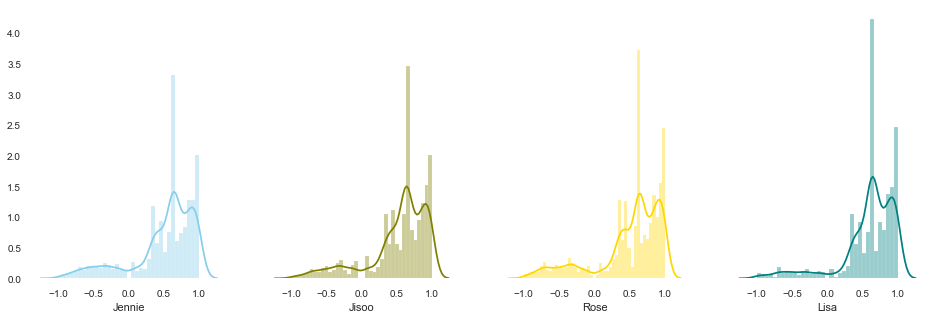

In [265]:
f, axes = plt.subplots(1, 4, figsize=(16, 5), sharex=True, sharey=True)
sns.distplot(no_neutral_jennie[1] , color="skyblue", ax=axes[0])
sns.distplot(no_neutral_jisoo[1], color="olive", ax=axes[1])
sns.distplot(no_neutral_lisa[1] , color="gold", ax=axes[2])
sns.distplot(no_neutral_rose[1] , color="teal", ax=axes[3])

axes[0].set(xlabel='Jennie')
axes[1].set(xlabel='Jisoo')
axes[2].set(xlabel='Rose')
axes[3].set(xlabel='Lisa')

In essence, we took the really large bar in the middle and removed it. This allows us to blow up the remaining parts of the graph.
This should be mostly expected. After all, most people who post on a music video would be fans. However, it'll be interesting to see how much of a difference having less misclassified samples would do to the distribution of sentiment.

In [266]:
positive, negative, neutral = 0, 0, 0
for sentiment in cleaned_lisa_sentiment:
    if .05 < sentiment < 1:
        positive += 1
    elif -0.05 < sentiment < 0.05:
        neutral += 1
    else:
        negative += 1

In [268]:
print(positive, negative, positive / (negative + positive))

9173 1679 0.845281975672687


In [271]:
for index,  sentiment_comment in enumerate(zip(cleaned_lisa_sentiment, lisa)):
    if 0.9 < sentiment_comment[0] <= 1:
        print(f"index: {index}", sentiment_comment[0], ':', sentiment_comment[1])
        print('-'*80)
        
# 3457, 2986, 2804, 8322 for lisa

index: 15 0.9846 : As you can see during Lisa's rap they used the idol of Lord Ganesha but they certainly kept it on the floor and Lisa also wore shoes near the idol, in Hindu culture Lord Ganesha @1:20 (in the bottom left corner)he is worshiped before starting any work as he is known for providing good luck and success. In Hinduism, when idols are placed they are placed in a specific manner, and also wearing shoes near it isn't allowed. So, what is done here in the mv it's disrespectful for a whole culture, I hope the company apologies for the mistake before it becomes a bigger matter, thank you and good luck for the next song :)
--------------------------------------------------------------------------------
index: 18 1.0 : Lisa ❤️Lisa❤️Lisa ❤️Lisa ❤️Lisa❤️Lisa ❤️Lisa ❤️Lisa❤️Lisa ❤️Lisa ❤️Lisa❤️Lisa ❤️Lisa ❤️Lisa❤️Lisa ❤️Lisa ❤️Lisa❤️Lisa ❤️Lisa ❤️Lisa❤️Lisa ❤️Lisa ❤️Lisa❤️Lisa ❤️Lisa ❤️Lisa❤️Lisa ❤️Lisa ❤️Lisa❤️Lisa ❤️Lisa ❤️Lisa❤️Lisa ❤️Lisa ❤️Lisa❤️Lisa ❤️Lisa ❤️Lisa❤️Lisa ❤️Lisa

--------------------------------------------------------------------------------
index: 3682 0.9766 : LISA QUEEN 💖💖💖💖
--------------------------------------------------------------------------------
index: 3688 0.9559 : Look at you 
Now look at me 
Wow lisa love u 💕💕
--------------------------------------------------------------------------------
index: 3689 0.9774 : Lisa 🥰🥰🥰 cant move my eyes from her ☺️
--------------------------------------------------------------------------------
index: 3703 0.9666 : Lalisa 😍😘😘😘😘😘😘😘
--------------------------------------------------------------------------------
index: 3705 0.9675 : I always want to say that Jiso is very beautiful!  Jenny shines so brightly!  Rosie is so cute!  Lisa is so attractive!  But I can't choose one. You are all beautiful and first class, I love you girls.
--------------------------------------------------------------------------------
index: 3714 0.9274 : Lisaaaaaaaaaaaa ❤❤❤🤪🤪🤯🤯🤪🤪
-----------------------------------------

index: 7221 0.9274 : Lisa💜💜💜Streaming!!!!!
--------------------------------------------------------------------------------
index: 7222 0.9719 : Lisa ❤❤❤❤❤streaming!!!
--------------------------------------------------------------------------------
index: 7224 0.975 : Love you lisaa😍😍😍💗💗
--------------------------------------------------------------------------------
index: 7248 0.9325 : Lisa ❤️❤️😘😘
--------------------------------------------------------------------------------
index: 7255 0.9854 : so here's my honest opinion. my first impression of the song was like what the heck was that? quite random words and beats and Am I hearing some nasty words like below the belt kinda?...lol, but nice outfits, and music video not to mention a very hard and tiring dance (AWESOME!)......then again I thought hey wait it's in Korean so I clicked the replay and cc buttons to see the translation....and wow Am I shocked! it is indeed an all Korean word except the parts where the chorus and the rap 

index: 10611 0.9953 : Omg Lalisa so butiful😍😍😍😍😘😗😗😗😗😚😚😙😍😍😲😲😲
--------------------------------------------------------------------------------
index: 10621 0.9274 : love you lisa💟💟
--------------------------------------------------------------------------------
index: 10627 0.9597 : I feel like this song didn't give enough time for all the members to shine but nonetheless it was an AMAZING comeback! Cant wait for more ...LISA'S RAP SLAYEDDD...ALL their outfits are beautiful and iconic...and the dance break is so POWERFUL
--------------------------------------------------------------------------------
index: 10635 0.936 : I always love when you said "blackpink in your area" LISA!!! Your hair is so hot in this video! Good luck Black Pink! And Love you LISA!!!!
--------------------------------------------------------------------------------
index: 10638 0.9571 : Lisa ♥♥♥♥
--------------------------------------------------------------------------------
index: 10646 0.9081 : Quá xuất sắc quá

index: 14712 0.9666 : omoooooooo lisaaaaaaaa♥️♥️♥️♥️😘
--------------------------------------------------------------------------------
index: 14721 0.9959 : Lisa 🔥🔥☺☺😊😊😚😚🥰🥰😘😘❤❤😍😍🤩🤩🤗🤗
--------------------------------------------------------------------------------
index: 14725 0.9001 : Lisa sister rap amazing godd👍🏻❤😍
--------------------------------------------------------------------------------
index: 14741 0.9501 : Lisa,Jiao🥰😍😘😚
--------------------------------------------------------------------------------
index: 14749 0.9022 : Love u all and support Lisa from Thailand 🇹🇭❤
--------------------------------------------------------------------------------
index: 14752 0.9201 : Perfect!!! I love you lisaaaaaa♥️
--------------------------------------------------------------------------------
index: 14790 0.9001 : Lisa😍😍😍😍
--------------------------------------------------------------------------------
index: 14798 0.9976 : Lisa😍😍😍😍
❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️
LISA.LISA.LISA....
----

index: 18069 0.9517 : Lisaa😍😍😍😍😍😍
--------------------------------------------------------------------------------
index: 18071 0.9954 : AIM STARTING TO ADDICTED TO 
BLACKPINK

KIM JISOO 😍😍😍❤❤

JENNY KIM😍😍😍❤❤

LISA MANOBAN😍😍😍❤❤❤👑👑👑 QUEEN 
 
HO ARE THEY GUY'S
--------------------------------------------------------------------------------
index: 18088 0.9287 : Lisa ♥️♥️💕
--------------------------------------------------------------------------------
index: 18097 0.9274 : Lisa 💝💝💝
--------------------------------------------------------------------------------
index: 18100 0.9153 : Wow 247m 😍😍😍 lisa
--------------------------------------------------------------------------------
index: 18104 0.9999 : 🖤💗🖤💗
🖤💗Q🖤💗
🖤💗QU🖤💗
🖤💗QUE🖤💗
🖤💗QUEE🖤💗
🖤💗QUEEN🖤💗
🖤💗QUEEN L🖤💗
🖤💗QUEEN LI🖤💗
🖤💗QUEEN LIS🖤💗
🖤💗QUEEN LISA🖤💗
🖤💗QUEEN LIS🖤💗
🖤💗QUEEN LI🖤💗
🖤💗QUEEN L🖤💗
🖤💗QUEEN🖤💗
🖤💗QUEE🖤💗
🖤💗QUE🖤💗
🖤💗QU🖤💗
🖤💗Q🖤💗
🖤💗🖤💗
BLACKPINK!
--------------------------------------------------------------------------------
index: 18112 0.9

In [ ]:
3457, 2986, 2804, 8322

# A closer look at just the emojis themselves

In [355]:
print(len(all_emojis))

1326


In [356]:
emojis = pd.DataFrame.from_dict(all_emojis.items())

emojis.columns = ['emoji', 'emoji_count']

emojis.head()

emojis['sentiment'] = [analyzer.polarity_scores(an_emoji)['compound'] for an_emoji in emojis['emoji']]

In [357]:
emojis.shape

(1326, 3)

In [358]:
emojis.head()

,emoji,emoji_count,sentiment
0,😂,25325,0.4404
1,🤲,173,0.0000
2,🏻,9184,0.0000
3,😄,5102,0.6705
4,😍,75246,0.4588


In [359]:
emojis.describe()

,emoji_count,sentiment
count,1326.000000,1326.000000
mean,910.923077,0.021666
std,4811.313774,0.157074
min,1.000000,-0.700300
25%,13.000000,0.000000
50%,45.000000,0.000000
75%,215.000000,0.000000
max,102283.000000,0.807400


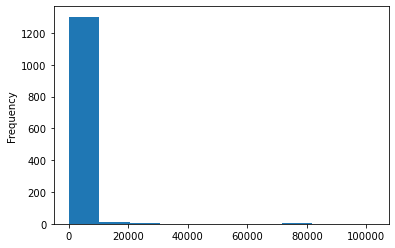

In [360]:
emojis['emoji_count'].plot.hist()

More than half of all the emojis in our corpus were used less than 10,000 times. Let's see what the ten top most common emojis are.

In [361]:
emojis.nlargest(10, 'emoji_count')

,emoji,emoji_count,sentiment
5,❤,102283,0.6369
4,😍,75246,0.4588
6,️,72065,0.0000
41,💜,39197,0.6369
27,🖤,27297,0.6369
59,💖,26559,0.7506
26,😘,25792,0.4215
0,😂,25325,0.4404
214,🤢,22786,0.0000
28,💗,21602,0.7096


The top ten most commons in the neutral category are emojis that are mostly positive, with the exception of the ambiguous '😂' and quite obviously negative '🤢'. In this case, I think '🤢' is a relatively new emoji, and thus vader Sentiment's lexicon just hasn't been updated to include that yet. I'm alos not quite sure if the third most common emoji, '', is just a whitespace that my function thought was an emoji, or if it's just not rendering properly on this machine.

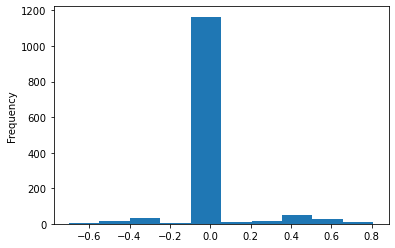

In [362]:
emojis['sentiment'].plot.hist()

This is also surprising! In general, we'd expect emojis to carry positive or negative sentiment. On a music video, we'd expect this behavior to be further polarized. However it seems like the emojis used are predominantly neutral. But let's take a closer look and see if this is actually the case, or just misclassification.

In [366]:
neutral = emojis[(-0.05 < emojis.sentiment) & (emojis.sentiment < 0.05)]

In [367]:
neutral_toptwenty = neutral.nlargest(20, 'emoji_count')
neutral_toptwenty['text'] = [emoji.demojize(str(an_emoji)) for an_emoji in neutral_toptwenty['emoji']]

In [368]:
neutral_toptwenty

,emoji,emoji_count,sentiment,text
6,️,72065,0.0,
214,🤢,22786,0.0,:nauseated_face:
289,💩,15881,0.0,:pile_of_poo:
215,🤮,15667,0.0,:face_vomiting:
232,👎,15064,0.0,:thumbs_down:
43,👍,13977,0.0,:thumbs_up:
57,🤩,10855,0.0,:star-struck:
2,🏻,9184,0.0,:light_skin_tone:
17,👑,8181,0.0,:crown:
152,😑,8106,0.0,:expressionless_face:


In [369]:
neutral_toptwenty.drop(6, axis='index', inplace=True)

neutral_toptwenty.drop(140, axis='index', inplace=True)

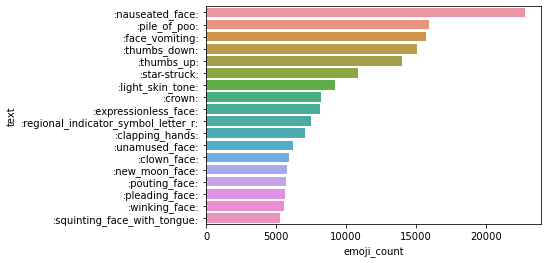

In [370]:
sns.barplot(y=neutral_toptwenty['text'], x=neutral_toptwenty['emoji_count'])

In [371]:
neutral_toptwenty

,emoji,emoji_count,sentiment,text
214,🤢,22786,0.0,:nauseated_face:
289,💩,15881,0.0,:pile_of_poo:
215,🤮,15667,0.0,:face_vomiting:
232,👎,15064,0.0,:thumbs_down:
43,👍,13977,0.0,:thumbs_up:
57,🤩,10855,0.0,:star-struck:
2,🏻,9184,0.0,:light_skin_tone:
17,👑,8181,0.0,:crown:
152,😑,8106,0.0,:expressionless_face:
240,🇷,7463,0.0,:regional_indicator_symbol_letter_r:


These are probably new emojis that haven't been added to the dictionary yet. I would be hard-pressed to find someone who'd think the nauseated face emoji is neutral. Others are quite ambiguous; for example, the pleading face, winking face, and squinting face with tongue could go either way. Others, like crown, thumbs_down, and thumbs_up have an obvious sentiment, but probably don't exist in the lexicon yet. Honestly, these "neutral" emojis are mostly negative.

In [ ]:
# sort by time

# apply sentiment analysis



In [209]:
redefined = {
    '👑': '_best',
    '🧐': '_skeptical',
    '💩': '_shit',
    '🌷': '_beautiful',
    '🌹': '_affection',
    '👍': '_good',
    '🤪': '_crazy',
    '💅': '_indifferent',
    '🙉': '_amuse',
    '🙄': '_disappoint',
    '🔥': '_great!',
    '👏': '_applause',
    '😒': '_not amused',
    '😝': '_playful',
    '💔': '_sad', 
    '😋': '_delicious',
    '🤢': '_bad',
    '👎': '_bad',
    '👸': '_good',
    '🌼': '_appreciate',
    '🖕': '_bad',
    '✊': '_good',
    '😑': '_bored',
    '🌝': '_irony',
    '🤩': '_wow',
    '💯': '_great',
    '🤮': '_disgust',
    '🙂': '_satisfied',
    '🥱': '_bored',
    '😪': '_tired',
    '😣': '_frustration',
    '😜': '_fun',
    '🙈': '_oh my god',
    '😳': '_surprise',
    '🤷': '_indifference',
    '🥺': '_please',
    '🤬': '_curse',
    '🥵': '_sexy',
    '🌟': '_brilliant',
    '👁👄👁': '_confuse',
    '🤯': '_wow',
    '🤡': '_fool',
    '😆': '_haha',
    '😷': '_sick',
    '✔️': '_approval',
    '🤟': '_love',
    '🤨': '_skeptical',
    '😏': '_satisfaction',
    '🌚': '_ironic',
    '😐': '_irritation',
    '💄': '_glamour',
    '😖': '_frustrate',
    '🎊': '_congratulations',
    '😜': '_playful',
    '😡': '_anger',
    '😯': '_surprise',
    '🤭': '_shock',
    '🙃': '_frustration',
    '👊': '_celebrate',
    '💪': '_strong',
    '😶': '_awkward',
    '😥': '_sad',
    '🤤': '_yummy',
    '🤍': '_heart',
    '✔️': '_good',
    '😤': '_pride',
    '💥': '_wow',
    '🙏': '_blessing',
    '💣': '_amazing',
    '💫': '_great',
    '🤧': '_good',
    '💀': '_shock',
    'kill': '_great',
    'killed': '_great',
    'killing': '_great',
    '😂': '_obnoxious'
        
}

In [210]:
import json
with open('redefined.json', 'w') as fp:
    json.dump(redefined, fp)
